## Transformer Approach ADAM

### Import Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from data_pipeline import transformation_pipeline
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, regularizers

### Reading Data

In [3]:
data = pd.read_csv('D:/Downloads/final-year-project/data/preprocessed_train_data.csv')

### Creating a Pipeline Object & Cleaning Data

In [4]:
pipeline, data_cleaned = transformation_pipeline(
    data, building_id=122, meter=0, primary_use=99)


d:\Downloads\final-year-project\notebooks\data_fetcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['building_id', 'meter', 'primary_use'],
d:\Downloads\final-year-project\notebooks\data_fetcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "timestamp"] = pd.to_datetime(df.loc[:, "timestamp"])
d:\Downloads\final-year-project\notebooks\data_fetcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

### Transforming the Data and Display

In [5]:
transformed_data = pipeline.fit_transform(data_cleaned)

### Data Splitting

In [6]:
x_train, x_val, y_train, y_val = train_test_split(transformed_data[:, 1:],
                                                  transformed_data[:, 0],
                                                  test_size=0.2,
                                                  shuffle=False,
                                                  random_state=2021)

### Creating Time Series Data Generators

In [7]:
train_gen = tf.keras.preprocessing.sequence.TimeseriesGenerator(x_train,
                                                                y_train,
                                                                length=6, sampling_rate=1,
                                                                stride=1, batch_size=32
                                                                )

val_gen = tf.keras.preprocessing.sequence.TimeseriesGenerator(x_val,
                                                              y_val,
                                                              length=6, sampling_rate=1,
                                                              stride=1, batch_size=32
                                                              )

### Creating Model Class

In [9]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [10]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0.1,
    mlp_dropout= 0.1,
):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D()(x)

    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(1)(x)
    return tf.keras.Model(inputs, outputs)

In [11]:
model = build_model(
    (6, 12),  # 6 is for the window on our data 6 hours, and 11 for the features
    head_size=256,  # play with this
    num_heads=8,  # and this
    ff_dim=128,  # and this
    num_transformer_blocks= 4,  # and this
    mlp_units=[256],
    mlp_dropout=0.0,
    dropout=0.0,
)

In [12]:
model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
)

In [119]:
# Define the learning rate schedule (flexible)
# adjusts the learning rate dynamically, often starting with a larger learning rate 
# for faster convergence and reducing it over time to fine-tune the model.

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=0.001,
#     decay_steps=10000,
#     decay_rate=0.9
# )

# # Define the optimizer with the learning rate schedule
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# # Compile the model with the new optimizer
# model.compile(
#     loss="mse",
#     optimizer=optimizer
# )

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 12)]      0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 6, 12)       24          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 6, 12)       104460      ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

In [13]:
callbacks = [tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True)]

In [13]:
model.fit(train_gen, validation_data=val_gen,
          epochs=200,
          callbacks=callbacks,
          )

Epoch 1/200
219/219 [==============================] - 17s 56ms/step - loss: 0.1288 - val_loss: 0.0212
Epoch 2/200
219/219 [==============================] - 13s 60ms/step - loss: 0.0149 - val_loss: 0.0167
Epoch 3/200
219/219 [==============================] - 13s 58ms/step - loss: 0.0128 - val_loss: 0.0129
Epoch 4/200
219/219 [==============================] - 13s 60ms/step - loss: 0.0109 - val_loss: 0.0102
Epoch 5/200
219/219 [==============================] - 13s 58ms/step - loss: 0.0108 - val_loss: 0.0120
Epoch 6/200
219/219 [==============================] - 13s 59ms/step - loss: 0.0092 - val_loss: 0.0200
Epoch 7/200
219/219 [==============================] - 13s 59ms/step - loss: 0.0088 - val_loss: 0.0106
Epoch 8/200
219/219 [==============================] - 13s 60ms/step - loss: 0.0079 - val_loss: 0.0097
Epoch 9/200
219/219 [==============================] - 13s 61ms/step - loss: 0.0089 - val_loss: 0.0070
Epoch 10/200
219/219 [==============================] - 13s 60ms/step - l

### Model Performance (Before Tuning)

In [14]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Helper function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Helper function to calculate SMAPE
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Assuming you have the generators `train_gen` and `val_gen`
y_true_val = np.concatenate([y for x, y in val_gen], axis=0)
y_pred_val = model.predict(val_gen).flatten()

mse = mean_squared_error(y_true_val, y_pred_val)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_val, y_pred_val)
mape = mean_absolute_percentage_error(y_true_val, y_pred_val)
smape = symmetric_mean_absolute_percentage_error(y_true_val, y_pred_val)
forecast_bias = np.mean(y_pred_val - y_true_val)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')
print(f'SMAPE: {smape}')
print(f'Forecast Bias: {forecast_bias}')


55/55 [==============================] - 2s 27ms/step
MSE: 0.004887491879933259
RMSE: 0.06991059919592493
MAE: 0.05530205401760977
MAPE: 15.852741390998471
SMAPE: 16.911091153125255
Forecast Bias: -0.016030286222621207


### Cross-validation and Hyperparamter Tuning

In [14]:
import keras_tuner as kt

def model_builder(hp):
    input_shape = (6, 12)  # 6 hours, 12 features
    num_transformer_blocks = 4
    mlp_units = [256]

    # Hyperparameters to tune
    head_size = hp.Int('head_size', min_value=64, max_value=512, step=64)
    num_heads = hp.Int('num_heads', min_value=2, max_value=16, step=2)
    ff_dim = hp.Int('ff_dim', min_value=64, max_value=512, step=64)
    dropout_rate = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)
    mlp_dropout = hp.Float('mlp_dropout', min_value=0.0, max_value=0.5, step=0.1)

    # Model construction with the tuner's hyperparameters
    model = build_model(
        input_shape=input_shape,
        head_size=head_size,
        num_heads=num_heads,
        ff_dim=ff_dim,
        num_transformer_blocks=num_transformer_blocks,
        mlp_units=mlp_units,
        dropout=dropout_rate,
        mlp_dropout=mlp_dropout,
    )
    model.compile(optimizer='adam', loss='mse')

    return model

# Initialize the tuner
tuner = kt.RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=5,  # Number of different configurations to try
    executions_per_trial=1,  # Number of models to train per trial
    directory='my_dir',
    project_name='transformer_tuning'
)

# Callbacks
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Start the hyperparameter search
tuner.search(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[stop_early]
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of heads is {best_hps.get('num_heads')},
the optimal head size is {best_hps.get('head_size')},
the optimal feed-forward dimension is {best_hps.get('ff_dim')},
the optimal dropout rate is {best_hps.get('dropout')},
and the optimal MLP dropout is {best_hps.get('mlp_dropout')}.
""")

best_model = tuner.hypermodel.build(best_hps)
best_model.fit(train_gen, validation_data=val_gen, epochs=200, callbacks=[stop_early])


Reloading Tuner from my_dir\transformer_tuning\tuner0.json

The optimal number of heads is 10,
the optimal head size is 320,
the optimal feed-forward dimension is 384,
the optimal dropout rate is 0.4,
and the optimal MLP dropout is 0.1.

Epoch 1/200
219/219 [==============================] - 25s 90ms/step - loss: 0.1926 - val_loss: 0.0376
Epoch 2/200
219/219 [==============================] - 20s 92ms/step - loss: 0.0243 - val_loss: 0.0097
Epoch 3/200
219/219 [==============================] - 20s 90ms/step - loss: 0.0181 - val_loss: 0.0084
Epoch 4/200
219/219 [==============================] - 21s 95ms/step - loss: 0.0133 - val_loss: 0.0106
Epoch 5/200
219/219 [==============================] - 26s 117ms/step - loss: 0.0111 - val_loss: 0.0114
Epoch 6/200
219/219 [==============================] - 25s 115ms/step - loss: 0.0105 - val_loss: 0.0062
Epoch 7/200
219/219 [==============================] - 25s 115ms/step - loss: 0.0102 - val_loss: 0.0081
Epoch 8/200
219/219 [=================

In [43]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.4):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size=320,
    num_heads=10,
    ff_dim=384,
    num_transformer_blocks=4,
    mlp_units=[256],
    dropout=0.4,
    mlp_dropout=0.1,
):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D()(x)

    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(1)(x)  # Assuming a regression task
    return tf.keras.Model(inputs, outputs)

# Define input shape and create the model
input_shape = (6, 12)  # 6 time steps and 12 features
final_model = build_model(input_shape)

# Compile the model
final_model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
)

# Model training callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=10, restore_best_weights=True)
]

# Start model training
final_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=200,
    callbacks=callbacks,
)

# Optionally, display the model architecture
final_model.summary()


Epoch 1/200
219/219 [==============================] - 30s 104ms/step - loss: 0.0927 - val_loss: 1.5632
Epoch 2/200
219/219 [==============================] - 24s 108ms/step - loss: 0.0906 - val_loss: 1.6873
Epoch 3/200
219/219 [==============================] - 21s 98ms/step - loss: 0.0888 - val_loss: 1.7716
Epoch 4/200
219/219 [==============================] - 21s 95ms/step - loss: 0.0891 - val_loss: 1.5285
Epoch 5/200
219/219 [==============================] - 21s 95ms/step - loss: 0.0880 - val_loss: 1.1042
Epoch 6/200
219/219 [==============================] - 22s 101ms/step - loss: 0.0880 - val_loss: 0.6780
Epoch 7/200
219/219 [==============================] - 21s 98ms/step - loss: 0.0883 - val_loss: 0.7047
Epoch 8/200
219/219 [==============================] - 20s 90ms/step - loss: 0.0870 - val_loss: 0.6403
Epoch 9/200
219/219 [==============================] - 21s 97ms/step - loss: 0.0870 - val_loss: 0.6763
Epoch 10/200
219/219 [==============================] - 21s 98ms/step 

In [15]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Helper function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Helper function to calculate SMAPE
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Assuming you have the generators `train_gen` and `val_gen`
y_true_val = np.concatenate([y for x, y in val_gen], axis=0)
y_pred_val = best_model.predict(val_gen).flatten()

mse = mean_squared_error(y_true_val, y_pred_val)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_val, y_pred_val)
mape = mean_absolute_percentage_error(y_true_val, y_pred_val)
smape = symmetric_mean_absolute_percentage_error(y_true_val, y_pred_val)
forecast_bias = np.mean(y_pred_val - y_true_val)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')
print(f'SMAPE: {smape}')
print(f'Forecast Bias: {forecast_bias}')


55/55 [==============================] - 2s 30ms/step
MSE: 0.004236764182640814
RMSE: 0.0650904308069997
MAE: 0.04837676070574069
MAPE: 13.681443275284453
SMAPE: 12.577869938489394
Forecast Bias: 0.018474812029485543


In [16]:
best_model.save('models/Transformer_ADAM')

INFO:tensorflow:Assets written to: models/Transformer_ADAM\assets


INFO:tensorflow:Assets written to: models/Transformer_ADAM\assets


### Displaying One Batch of Validation Data
#### 7 = batch 
#### 0 = features
#### 1 = output

In [171]:
display(val_gen[7][1])

array([0.3465129 , 0.35118067, 0.37726524, 0.3734212 , 0.36463482,
       0.35694673, 0.35914333, 0.35172982, 0.34239429, 0.34184514,
       0.3239978 , 0.30395387, 0.31246568, 0.31383855, 0.31164195,
       0.3261944 , 0.32344865, 0.31850632, 0.30834706, 0.30093355,
       0.29763866, 0.3036793 , 0.30477759, 0.31933004, 0.33305876,
       0.33168589, 0.31768259, 0.32894014, 0.33250961, 0.31658429,
       0.32811642, 0.3261944 ])

### Predicting Particular Batch

In [172]:
predicted_batch_7 = model.predict(val_gen[7][0])

1/1 [==============================] - 0s 348ms/step


### Plotting the Prediction VS the Actual

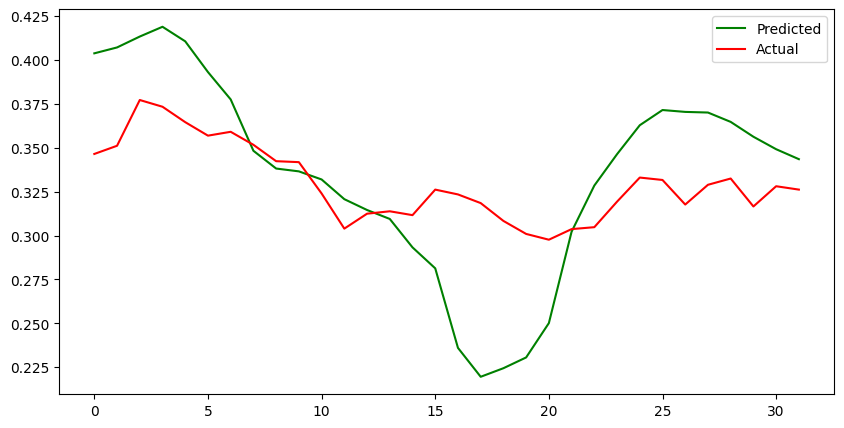

In [173]:
_, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(32),
        predicted_batch_7,
        color='green', label='Predicted')

ax.plot(range(32),
        val_gen[7][1],
        color='red', label='Actual')
ax.legend()

plt.show()

### Predicting the Whole Batches

In [127]:
predicted = []
actual = []
for i in range(32):
    predicted.extend(model.predict(val_gen[i][0]))
    actual.extend(val_gen[i][1])


1/1 [==============================] - 0s 48ms/step


In [25]:
predicted_t = []
actual_t = []
for i in range(32):
    predicted_t.extend(model.predict(train_gen[i][0]))
    actual_t.extend(train_gen[i][1])

1/1 [==============================] - 0s 21ms/step


In [26]:
print('Testing Loss= ', np.mean(tf.keras.losses.MSE(actual, predicted)))
# the mean loss= 0.02899

Testing Loss=  0.023742199


### Plotting the Validation Set Output VS Predicted Value

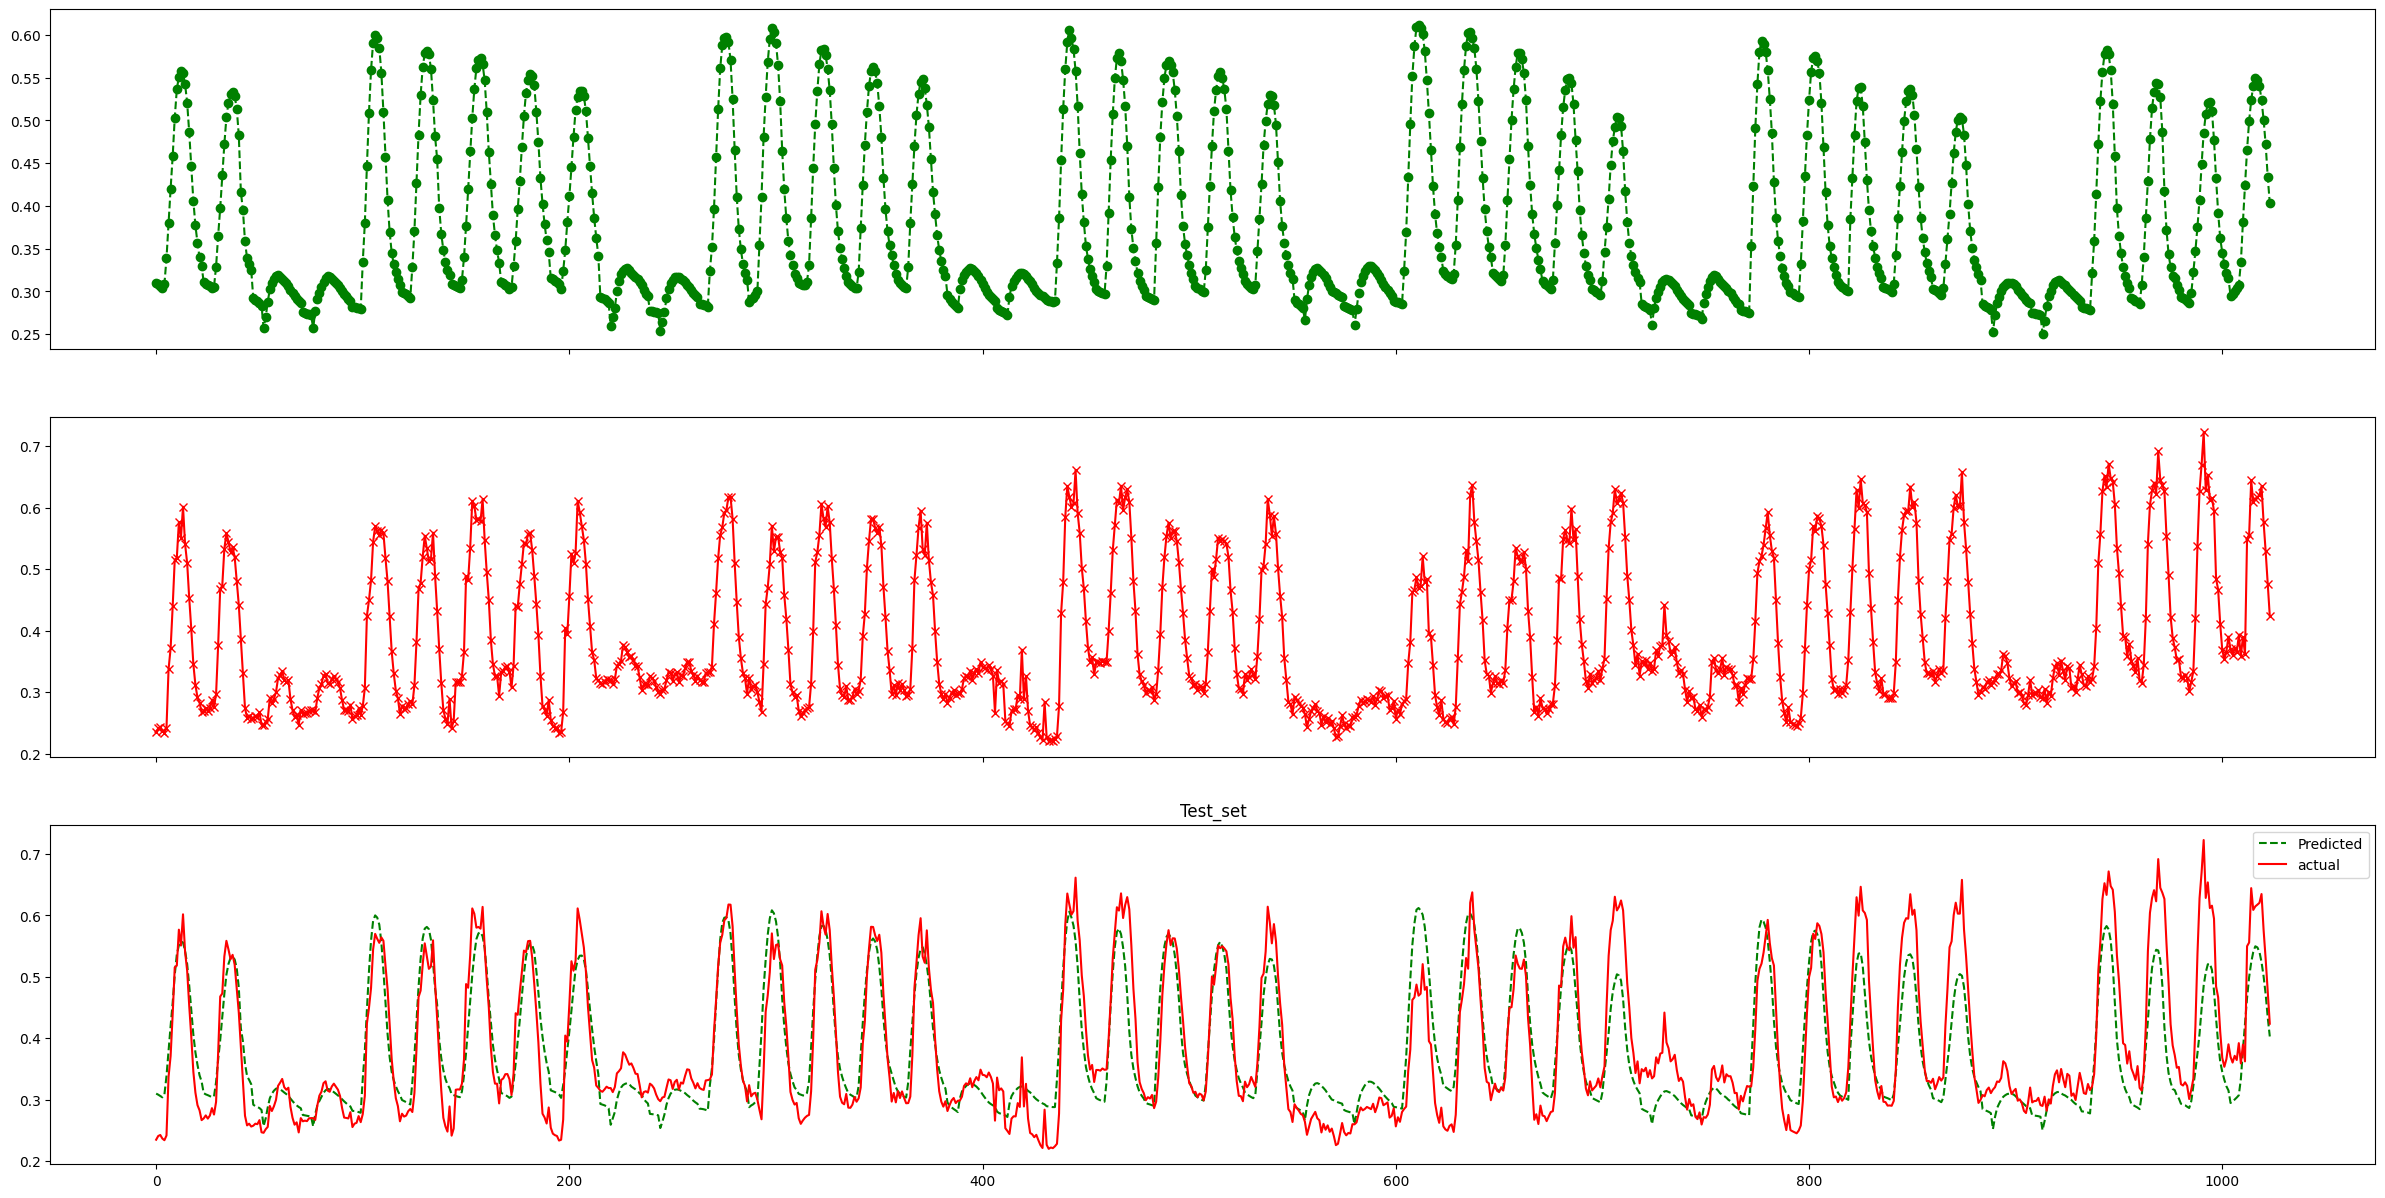

In [27]:
fig, (ax1, ax2, ax) = plt.subplots(3, 1,  figsize=(30, 15), sharex=True)

ax1.plot(range(len(actual)),
         predicted,
         color='green', marker='o', linestyle='dashed', label='Predicted')
plt.legend()

ax2.plot(range(len(actual)),
         actual,
         color='red', marker='x', label='Actual')
plt.legend()

ax.plot(range(len(actual)),
        predicted,
        color='green', linestyle='dashed',
        label='Predicted')
plt.legend()
ax.plot(range(len(actual)),
        actual,
        color='red',
        label='actual')

plt.legend()

plt.title('Test_set', loc='center')

plt.show()

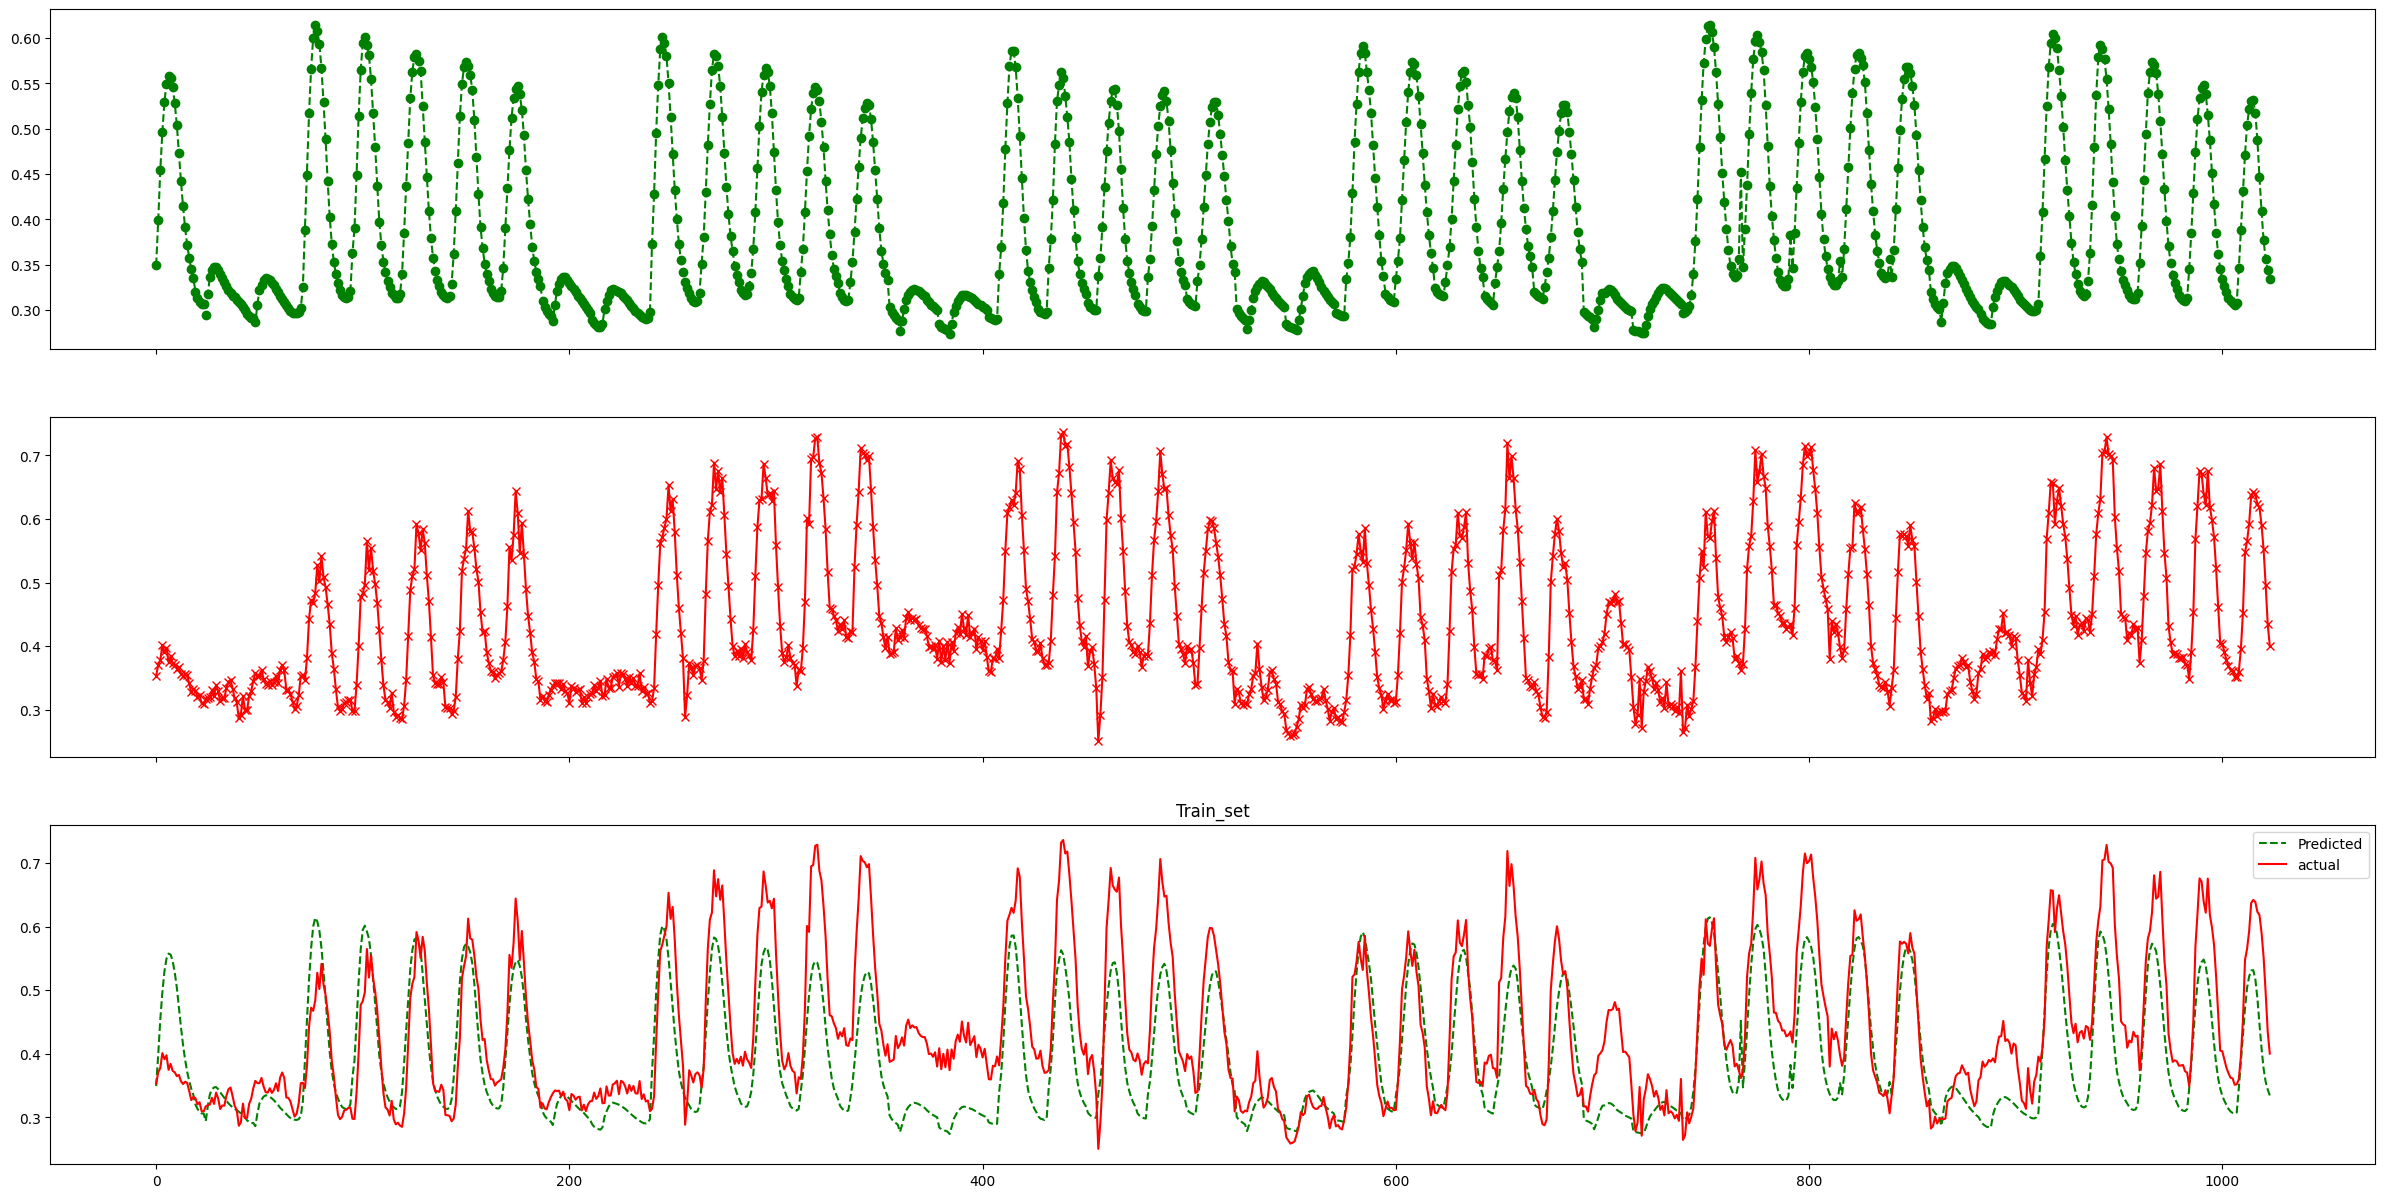

In [28]:
fig, (ax1, ax2, ax) = plt.subplots(3, 1,  figsize=(30, 15), sharex=True)

ax1.plot(range(len(actual_t)),
         predicted_t,
         color='green', marker='o', linestyle='dashed',
         label='Predicted')

ax2.plot(range(len(actual_t)),
         actual_t,
         color='red', marker='x', label='Actual')


ax.plot(range(len(actual_t)),
        predicted_t,
        color='green', linestyle='dashed',
        label='Predicted')

ax.plot(range(len(actual_t)),
        actual_t,
        color='red',
        label='actual')
plt.title('Train_set', loc='center')

plt.legend()

plt.show()

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 12)]      0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 6, 12)       104460      ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 6, 12)        0           ['multi_head_attention[0][0]']   
                                                                                                  
 layer_normalization (LayerNorm  (None, 6, 12)       24          ['dropout[0][0]']            